In [1]:
from cloudscape import (
    load_studies,
    calculate_2d_cooccurence_df_plus_listofmore,
    normalize_dict,
    extract_svc_info,
)
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

architectures = load_studies("./data/graphs/")
svc_description_fname = "./data/services.csv"

svc_info = extract_svc_info(svc_description_fname)


def is_ml(svc):
    return "ML" in svc_info[svc]["aws_product_categories"].split(",")


def is_analytics(svc):
    return "Analytics" in svc_info[svc]["aws_product_categories"].split(",")


def is_storage(svc):
    return (
        svc_info[svc]["capability"] == "storage" and svc != "EBS"
    )  # since all other svcs are built on top of it.


def cleanup(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


CAPABILITY_COLORS = {
    "compute": "#FF7F0E",
    "storage": "#1F77B4",
    "networking": "#2CA02C",
    "integration": "#FFBB78",
    "control": "#AEC7E8",
    "other": "#98DF8A",
    "User": "gray",
    "ThirdParty": "lightgray",
    "OnPremDC": "black",
    "Partner": "black",
}

schema_colors = OrderedDict()
schema_colors["object"] = "#2CA02C"
schema_colors["specialized"] = "#BCBD22"
schema_colors["nosql"] = "#1F77B4"
schema_colors["sql"] = "#9467BD"
schema_colors["fs"] = "#D62728"

# Dataset Analysis

In [2]:
print(f"There are {len(architectures)} architectures in the dataset.")
architectures = [a for a in architectures if a.use_for_analysis()]
print(f"We will analyze {len(architectures)} of them.")

There are 396 architectures in the dataset.
We will analyze 340 of them.


In [3]:
all_categories = set()
for s in architectures:
    all_categories.update(s.get_functional_goals())

all_categories = list(all_categories)
df, _, _, _ = calculate_2d_cooccurence_df_plus_listofmore(
    architectures, all_categories, lambda x: x.get_functional_goals()
)
df

,compute_intensive,control,interactive,data_ingestion,other
compute_intensive,10% (35),0% (1),1% (6),2% (9),0% (0)
control,0% (1),12% (41),2% (7),0% (0),0% (0)
interactive,1% (6),2% (7),22% (78),8% (28),0% (0)
data_ingestion,2% (9),0% (0),8% (28),34% (116),0% (0)
other,0% (0),0% (0),0% (0),0% (0),5% (17)
Total,15% (51),14% (49),35% (119),45% (153),5% (17)


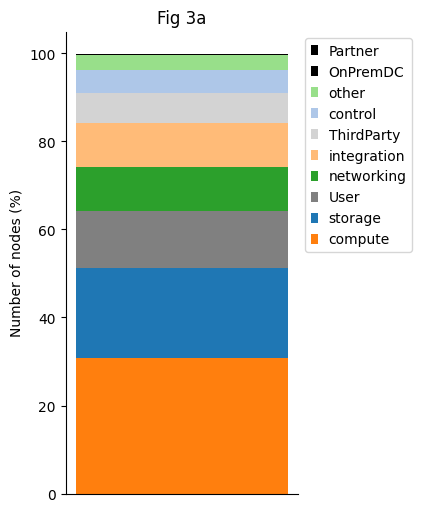

In [4]:
def fig_3a(architectures):
    """Proportion of each type of service in the dataset"""
    # query
    occurence = Counter()
    for arch in architectures:
        occurence.update(
            svc_info[x]["capability"] for x in arch.get_all_nodes_services()
        )
    occurence = Counter(normalize_dict(occurence, sum(occurence.values())))

    # plotting
    fig, ax = plt.subplots(figsize=(3, 6))
    bottom = 0
    for classification, usage in occurence.most_common():
        ax.bar(
            0,
            usage,
            bottom=bottom,
            label=classification,
            color=CAPABILITY_COLORS[classification],
        )
        bottom += usage

    ax.set_xticks([])
    ax.set_ylabel("Number of nodes (%)")
    ax.legend(handlelength=0.5, loc="upper left", bbox_to_anchor=(1, 1), reverse=True)
    plt.title("Fig 3a")
    cleanup()
    plt.show()


fig_3a(architectures)

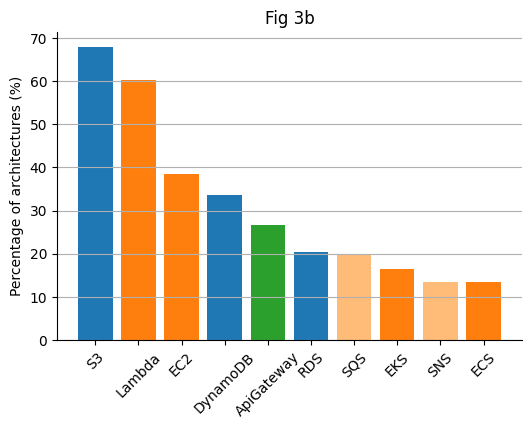

In [5]:
def fig_3b(architectures):
    """Most popular AWS services used by architectures"""
    # query
    occurence = Counter()
    for arch in architectures:
        occurence.update(
            x for x in set(arch.get_all_nodes_services()) if svc_info[x]["is_aws"]
        )

    occurence = Counter(normalize_dict(occurence, len(architectures)))

    # plotting
    fig, ax = plt.subplots(figsize=(6, 4))
    x = np.arange(10)
    x_names, y = zip(*occurence.most_common(10))
    colors = [CAPABILITY_COLORS[svc_info[x]["capability"]] for x in x_names]

    ax.bar(x, y, color=colors)
    ax.set_xticks(x)
    ax.set_xticklabels(x_names, rotation=45)
    ax.set_ylabel("Percentage of architectures (%)")
    ax.grid(axis="y")
    plt.title("Fig 3b")

    cleanup()


fig_3b(architectures)

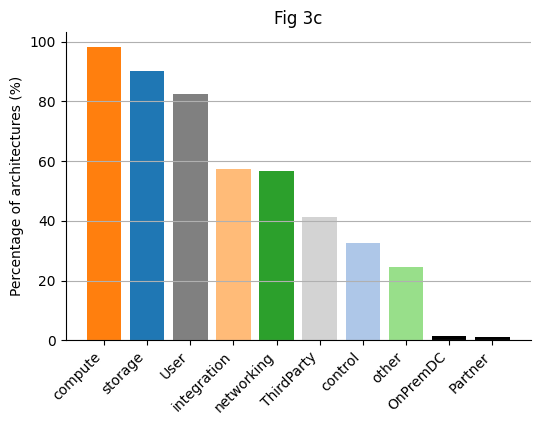

In [6]:
def fig_3c(architectures):
    """What percentage of architectures use each capability?"""
    # query
    occurence = Counter()
    for arch in architectures:
        services = (x for x in arch.get_all_nodes_services())
        capabilities = set(
            svc_info[x]["capability"] for x in services
        )  # use set to avoid double counting
        occurence.update(capabilities)

    occurence = Counter(normalize_dict(occurence, len(architectures)))

    # plotting
    fig, ax = plt.subplots(figsize=(6, 4))

    x = np.arange(len(occurence))
    x_names, y = zip(*occurence.most_common())
    colors = [CAPABILITY_COLORS[x] for x in x_names]

    ax.bar(x, y, color=colors)
    ax.set_xticks(x)
    ax.set_xticklabels(x_names, rotation=45, ha="right")
    ax.set_ylabel("Percentage of architectures (%)")
    ax.grid(axis="y")

    plt.title("Fig 3c")

    cleanup()


fig_3c(architectures)

In [7]:
def count_number_of_partner_and_onpremdc(architectures):
    total_partner_nodes, total_onpremdc_nodes = 0, 0
    for arch in architectures:
        total_partner_nodes += len(
            arch.select_nodes(
                lambda x: svc_info[x["service"]]["capability"] == "Partner"
            )
        )
        total_onpremdc_nodes += len(
            arch.select_nodes(
                lambda x: svc_info[x["service"]]["capability"] == "OnPremDC"
            )
        )
    print("Number of Partner nodes:", total_partner_nodes)
    print("Number of OnPremDC nodes:", total_onpremdc_nodes)


count_number_of_partner_and_onpremdc(architectures)

Number of Partner nodes: 4
Number of OnPremDC nodes: 5


#### There are fewer than 10 uses of partner or On-Premise-Datacenter nodes across the entire dataset, so we do not include them in our analysis or graphs in the paper.

# Storage Service Analysis

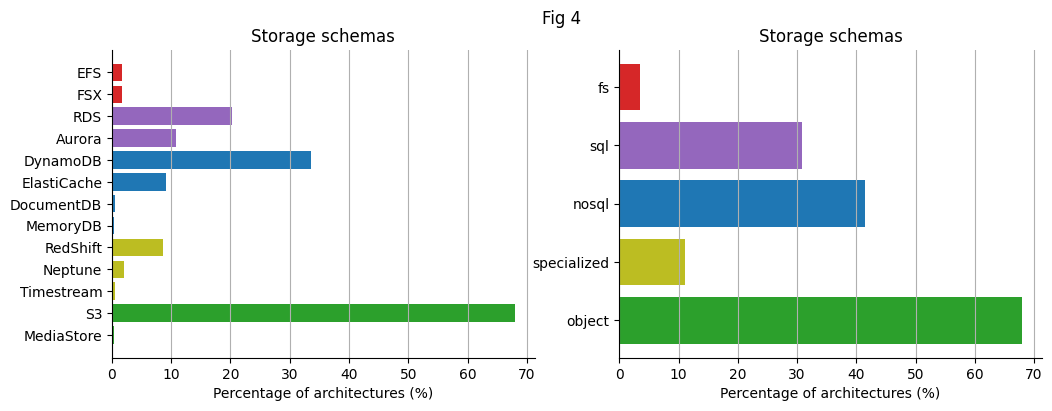

In [8]:
def fig_4(architectures):
    """Usage of different storage services / schemas"""
    # query
    service_occurence = Counter()
    schema_occurence = Counter()

    for arch in architectures:
        storage_svcs = set(filter(is_storage, arch.get_all_nodes_services()))
        storage_schemas = set(svc_info[x]["schema"] for x in storage_svcs)
        # sets to avoid double counting

        service_occurence.update(storage_svcs)
        schema_occurence.update(storage_schemas)

    service_occurence = Counter(normalize_dict(service_occurence, len(architectures)))
    schema_occurence = Counter(normalize_dict(schema_occurence, len(architectures)))

    # plotting
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    y_names, x = zip(*service_occurence.most_common())
    _schemas = [svc_info[t]["schema"] for t in y_names]
    colors = [schema_colors[t] for t in _schemas]

    # group by schema
    x, y_names, _schemas, colors = zip(
        *sorted(
            zip(x, y_names, _schemas, colors),
            key=lambda t: (list(schema_colors.keys()).index(t[2]), t[0]),
        )
    )

    y = np.arange(len(service_occurence))
    ax1.barh(y, x, color=colors)
    ax1.set_yticks(y)
    ax1.set_yticklabels(y_names)
    ax1.set_xlabel("Percentage of architectures (%)")
    ax1.set_title("Storage schemas")
    ax1.grid(axis="x")

    y = np.arange(len(schema_occurence))
    y_names = list(schema_colors.keys())
    x = [schema_occurence[t] for t in y_names]
    colors = [schema_colors[t] for t in y_names]

    ax2.barh(y, x, color=colors)
    ax2.set_yticks(y)
    ax2.set_yticklabels(y_names)
    ax2.set_xlabel("Percentage of architectures (%)")
    ax2.set_title("Storage schemas")
    ax2.grid(axis="x")

    plt.suptitle("Fig 4")

    cleanup(ax1)
    cleanup(ax2)


fig_4(architectures)

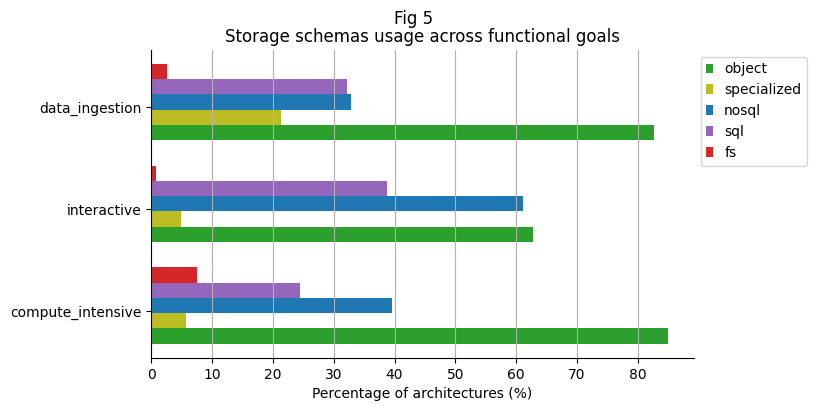

In [9]:
def fig_5(architectures):
    """Usage of storage schemas across functional goals"""
    # query
    functional_goals_to_consider = (
        "compute_intensive",
        "interactive",
        "data_ingestion",
    )
    df = pd.DataFrame(
        0, index=schema_colors.keys(), columns=functional_goals_to_consider
    )

    for arch in architectures:
        storage_svcs = filter(is_storage, arch.get_all_nodes_services())
        storage_schemas = set(svc_info[x]["schema"] for x in storage_svcs)

        for schema in storage_schemas:
            for fg in arch.get_functional_goals():
                if fg in functional_goals_to_consider:
                    df.loc[schema, fg] += 1

    # normalize based on total architectures per functional goal
    architectures_per_fg = {t: 0 for t in functional_goals_to_consider}
    for arch in architectures:
        for fg in arch.get_functional_goals():
            if fg in functional_goals_to_consider:
                architectures_per_fg[fg] += 1

    for fg in functional_goals_to_consider:
        df[fg] = df[fg] / architectures_per_fg[fg] * 100

    # plotting
    fig, ax = plt.subplots(figsize=(7, 4))
    width = 0.15
    y = np.arange(len(df.columns))

    for i, schema in enumerate(df.index):
        ax.barh(
            y + width * i,
            df.loc[schema],
            color=schema_colors[schema],
            label=schema,
            height=width,
        )

    ax.set_yticks(y + 0.25)
    ax.set_yticklabels(df.columns)
    ax.set_xlabel("Percentage of architectures (%)")
    ax.set_title("Storage schemas usage across functional goals")
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1), handlelength=0.5)
    ax.grid(axis="x")

    plt.suptitle("Fig 5")

    cleanup()


fig_5(architectures)

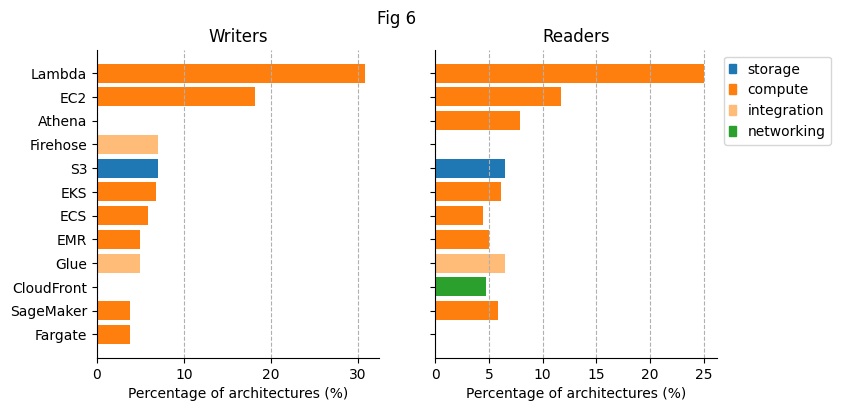

In [10]:
def fig_6(architectures):
    """Common readers and writers of storage services"""
    # query
    common_readers, common_writers = Counter(), Counter()

    for arch in architectures:
        storage_svcs = set(filter(is_storage, arch.get_all_nodes_services()))

        # For each architecture, we are counting the existence of a service reading from/writing to any storage service.
        # We are not counting the __number__ of times a service reads from/writes to a storage service.
        this_arch_readers, this_arch_writers = set(), set()
        for storage_svc in storage_svcs:
            _writer_nodes = arch.get_inbound_nodes_for_svc(storage_svc, data_only=True)
            this_arch_writers.update(t["service"] for t in _writer_nodes)

            _reader_nodes = arch.get_outbound_nodes_for_svc(storage_svc, data_only=True)
            this_arch_readers.update(t["service"] for t in _reader_nodes)

        common_readers.update(this_arch_readers)
        common_writers.update(this_arch_writers)

    del common_readers["ThirdParty"]  # we are concerned with AWS services only
    del common_writers["ThirdParty"]
    common_readers = Counter(normalize_dict(common_readers, len(architectures)))
    common_writers = Counter(normalize_dict(common_writers, len(architectures)))

    # plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    y_writer_names = [t[0] for t in common_writers.most_common(10)]
    y_reader_names = [t[0] for t in common_readers.most_common(10)]

    sorted_y_names = list(set(y_writer_names + y_reader_names))
    sorted_y_names.sort(
        key=lambda x: (common_writers[x] if x in y_writer_names else common_readers[x]),
        reverse=False,
    )
    colors = [CAPABILITY_COLORS[svc_info[x]["capability"]] for x in sorted_y_names]
    y = np.arange(len(sorted_y_names))

    x = [common_writers[t] if t in y_writer_names else 0 for t in sorted_y_names]
    ax1.barh(y, x, color=colors)
    ax1.set_yticks(y)
    ax1.set_yticklabels(sorted_y_names)
    ax1.set_xlabel("Percentage of architectures (%)")
    ax1.set_title("Writers")
    ax1.grid(axis="x", linestyle="--")

    x = [common_readers[t] if t in y_reader_names else 0 for t in sorted_y_names]
    ax2.barh(y, x, color=colors)
    ax2.set_yticks(y)
    ax2.set_yticklabels([""] * len(sorted_y_names))
    ax2.set_xlabel("Percentage of architectures (%)")
    ax2.set_title("Readers")
    ax2.grid(axis="x", linestyle="--")

    # legend
    capabilities_shown = set(svc_info[x]["capability"] for x in sorted_y_names)
    handles = [
        plt.Rectangle((0, 0), 1, 1, color=CAPABILITY_COLORS[cap])
        for cap in capabilities_shown
    ]
    ax2.legend(
        handles,
        capabilities_shown,
        loc="upper left",
        bbox_to_anchor=(1, 1),
        handlelength=0.5,
    )

    cleanup(ax1)
    cleanup(ax2)

    plt.suptitle("Fig 6")


fig_6(architectures)

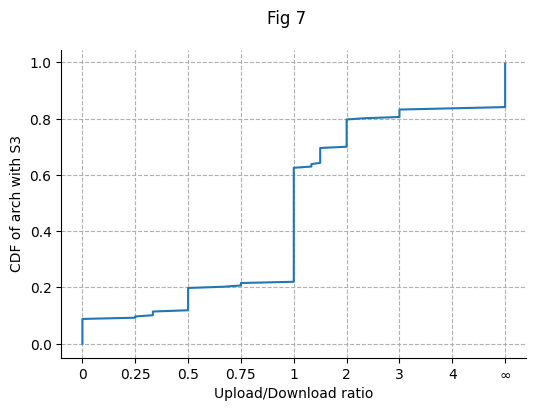

In [11]:
def fig_7(architectures):
    """ratio of upload/download edges for S3"""
    # query
    ratios = []
    for arch in architectures:
        download_edges = len(arch.get_outbound_nodes_for_svc("S3", data_only=True))
        upload_edges = len(arch.get_inbound_nodes_for_svc("S3", data_only=True))

        # only consider architectures with S3
        if download_edges == 0 and upload_edges == 0:
            continue

        ratio = upload_edges / download_edges if download_edges != 0 else float("inf")
        ratios.append(ratio)

    replace_inf = max([x for x in ratios if x != float("inf")]) + 1
    ratios = [replace_inf if x == float("inf") else x for x in ratios]

    # plotting
    def normalize_x(t):
        if t < 1:
            return t / 2  # half the graph is for t < 1. (t is already divided by 4.)
        # for the other half of the graph, divide it into 4 subsections (because numerator goes up to 4)
        return 0.5 + (t - 1) / 2 / 4

    y = np.arange(len(ratios)) / len(ratios)
    ratios.sort()
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.plot([normalize_x(x) for x in ratios], y)

    x_axis = [0, 1 / 4, 2 / 4, 3 / 4, 1, 2, 3, 4, 5]
    x_axis_str = ["0", "0.25", "0.5", "0.75", "1", "2", "3", "4", r"$\infty$"]
    ax.set_xticks([normalize_x(t) for t in x_axis], x_axis_str)

    ax.set_xlabel("Upload/Download ratio")
    ax.set_ylabel("CDF of arch with S3")
    ax.grid(linestyle="--")

    plt.suptitle("Fig 7")

    cleanup()


fig_7(architectures)

Percentage of architectures with at least 1 ML service: 18.235294117647058 %


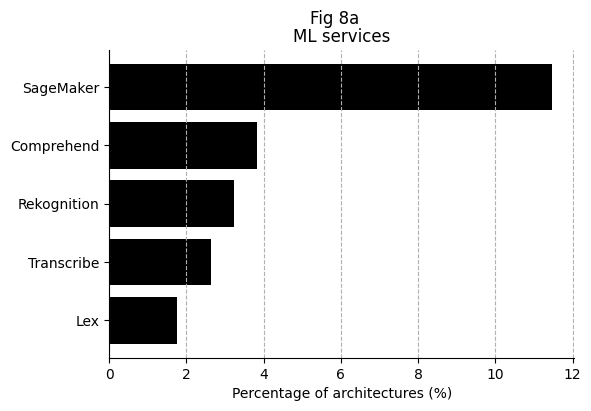

In [12]:
def fig_8a(architectures):
    """Presence of ML services in architectures"""
    # query
    occurences = Counter()
    arch_with_atleast_1_ml = 0
    for arch in architectures:
        svcs = arch.get_all_nodes_services()
        ml_svcs = set(filter(is_ml, svcs))

        occurences.update(set(ml_svcs))
        if ml_svcs:
            arch_with_atleast_1_ml += 1

    occurences = Counter(normalize_dict(occurences, len(architectures)))
    arch_with_atleast_1_ml = arch_with_atleast_1_ml / len(architectures) * 100
    print(
        "Percentage of architectures with at least 1 ML service:",
        arch_with_atleast_1_ml,
        "%",
    )

    # plotting
    fig, ax = plt.subplots(figsize=(6, 4))
    y = np.arange(5)
    y_names, x = zip(*reversed(occurences.most_common(5)))
    ax.barh(y, x, color="k")
    ax.set_yticks(y)
    ax.set_yticklabels(y_names)
    ax.set_xlabel("Percentage of architectures (%)")
    ax.set_title("ML services")
    ax.grid(axis="x", linestyle="--")

    plt.suptitle("Fig 8a")

    cleanup()


fig_8a(architectures)

The submitted version of the paper mistakenly reported that 26.5% of architectures have at least 1 ML service, instead of 18.2%. We will fix this in the final version.
This does not affect any claim made in the paper.

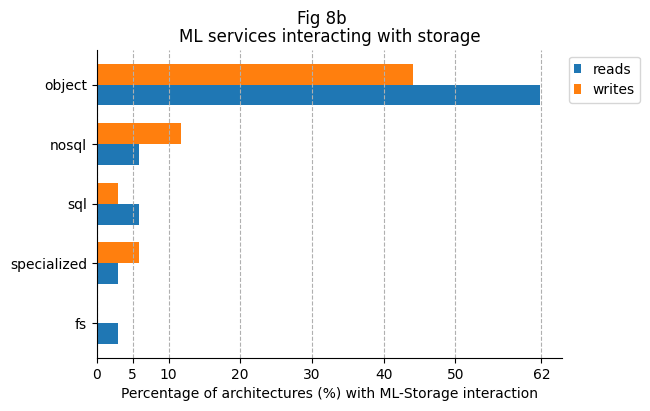

In [23]:
def fig_8b(architectures):
    all_schemas = ("fs", "specialized", "sql", "nosql", "object")

    # query
    df = pd.DataFrame(0, index=["reads", "writes"], columns=all_schemas)
    n_archs_where_ml_interacts_with_storage = 0

    for arch in architectures:
        schemas_used_in_this_arch_writer = set()
        schemas_used_in_this_arch_reader = set()
        ml_svcs = list(filter(is_ml, arch.get_all_nodes_services()))
        if not ml_svcs:
            continue

        for ml_svc in ml_svcs:
            writers_svcs = set(
                t["service"]
                for t in arch.get_outbound_nodes_for_svc(ml_svc, data_only=True)
            )
            readers_svcs = set(
                t["service"]
                for t in arch.get_inbound_nodes_for_svc(ml_svc, data_only=True)
            )

            writers_svcs = filter(is_storage, writers_svcs)
            readers_svcs = filter(is_storage, readers_svcs)

            for st_svc in writers_svcs:
                schemas_used_in_this_arch_writer.add(svc_info[st_svc]["schema"])
            for st_svc in readers_svcs:
                schemas_used_in_this_arch_reader.add(svc_info[st_svc]["schema"])

        if (
            not schemas_used_in_this_arch_writer
            and not schemas_used_in_this_arch_reader
        ):
            continue
        n_archs_where_ml_interacts_with_storage += 1

        for schema in schemas_used_in_this_arch_writer:
            df.loc["writes", schema] += 1
        for schema in schemas_used_in_this_arch_reader:
            df.loc["reads", schema] += 1

    df = df / n_archs_where_ml_interacts_with_storage * 100

    # plotting
    y = np.arange(len(all_schemas))
    fig, ax = plt.subplots(figsize=(6, 4))
    width = 0.35

    for i, action in enumerate(df.index):
        ax.barh(y + width * i, df.loc[action], label=action, height=width)

    ax.set_yticks(y + width / 2)
    ax.set_yticklabels(all_schemas)
    ax.set_xlabel("Percentage of architectures (%) with ML-Storage interaction")
    ax.set_title("ML services interacting with storage")
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1), handlelength=0.5)
    ax.grid(axis="x", linestyle="--")
    ax.set_xticks([0, 5, 10, 20, 30, 40, 50, 62])

    plt.suptitle("Fig 8b")

    cleanup()


fig_8b(architectures)

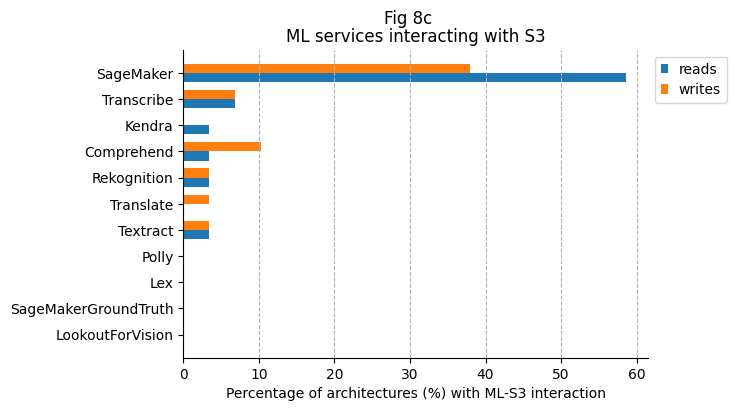

In [24]:
def fig_8c(architectures):
    """Percentage of ML services reading/writing from S3"""
    all_ml_svcs = [
        "SageMaker",
        "Transcribe",
        "Kendra",
        "Comprehend",
        "Rekognition",
        "Translate",
        "Textract",
        "Polly",
        "Lex",
        "SageMakerGroundTruth",
        "LookoutForVision",
    ][::-1]
    df = pd.DataFrame(0, index=["reads", "writes"], columns=all_ml_svcs)

    # query
    n_archs_where_ml_interacts_with_s3 = 0
    for arch in architectures:
        svcs_writing_to_s3 = arch.get_inbound_nodes_for_svc("S3", data_only=True)
        svcs_reading_from_s3 = arch.get_outbound_nodes_for_svc("S3", data_only=True)

        ml_svcs_writing_to_s3 = set(
            t["service"] for t in svcs_writing_to_s3 if is_ml(t["service"])
        )
        ml_svcs_reading_from_s3 = set(
            t["service"] for t in svcs_reading_from_s3 if is_ml(t["service"])
        )

        if not ml_svcs_writing_to_s3 and not ml_svcs_reading_from_s3:
            continue
        n_archs_where_ml_interacts_with_s3 += 1

        for ml_svc in ml_svcs_writing_to_s3:
            df.loc["writes", ml_svc] += 1
        for ml_svc in ml_svcs_reading_from_s3:
            df.loc["reads", ml_svc] += 1

    df = df / n_archs_where_ml_interacts_with_s3 * 100

    # plotting
    fig, ax = plt.subplots(figsize=(6, 4))
    y = np.arange(len(all_ml_svcs))
    width = 0.35

    for i, action in enumerate(df.index):
        ax.barh(y + width * i, df.loc[action], label=action, height=width)

    ax.set_yticks(y + width / 2)
    ax.set_yticklabels(all_ml_svcs)
    ax.set_xlabel("Percentage of architectures (%) with ML-S3 interaction")
    ax.set_title("ML services interacting with S3")
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1), handlelength=0.5)
    ax.grid(axis="x", linestyle="--")

    plt.suptitle("Fig 8c")

    cleanup()


fig_8c(architectures)

Percentage of architectures with at least 1 analytics service: 42.05882352941177 %


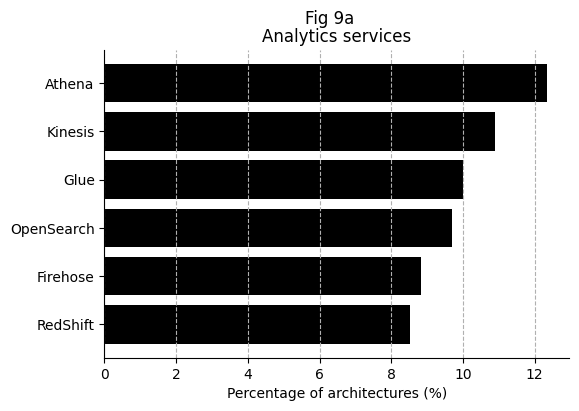

In [15]:
def fig_9a(architectures):
    """Presence of analytics services in architectures"""
    # query
    occurence = Counter()
    n_archs_with_analytics = 0
    for arch in architectures:
        svcs = arch.get_all_nodes_services()
        analytics_svcs = set(filter(is_analytics, svcs))

        if analytics_svcs:
            n_archs_with_analytics += 1
            occurence.update(analytics_svcs)

    occurence = Counter(normalize_dict(occurence, len(architectures)))
    n_archs_with_analytics = n_archs_with_analytics / len(architectures) * 100

    print(
        "Percentage of architectures with at least 1 analytics service:",
        n_archs_with_analytics,
        "%",
    )

    # plotting
    fig, ax = plt.subplots(figsize=(6, 4))
    y = np.arange(6)
    y_names, x = zip(*reversed(occurence.most_common(6)))
    ax.barh(y, x, color="k")

    ax.set_yticks(y)
    ax.set_yticklabels(y_names)
    ax.set_xlabel("Percentage of architectures (%)")
    ax.set_title("Analytics services")
    ax.grid(axis="x", linestyle="--")

    plt.suptitle("Fig 9a")

    cleanup()


fig_9a(architectures)

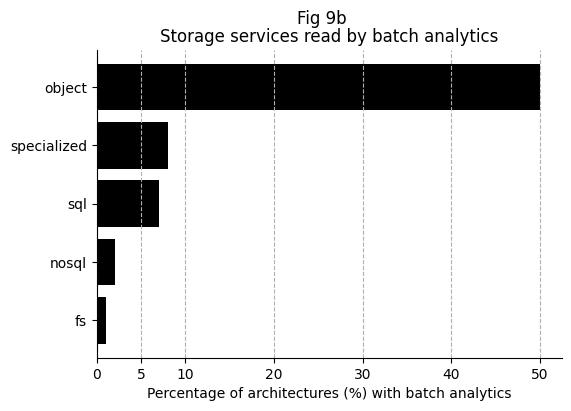

In [16]:
batch_svcs = ["Athena", "Glue", "RedShift", "OpenSearch", "QuickSight"]
streaming_svcs = [
    "Kinesis",
    "Firehose",
    "EMR",
    "MSK",
    "KinesisDataStream",
    "KinesisAnalytics",
    "KinesisVideo",
    "DataPipeline",
]


def fig_9b(architectures):
    """Storage services read by batch analytics svcs"""
    # query
    n_archs_with_atleast_1_batch = 0
    schemas_used = Counter()

    for arch in architectures:
        analytics_svcs_in_arch = set(
            filter(lambda x: x in batch_svcs, arch.get_all_nodes_services())
        )
        if not analytics_svcs_in_arch:
            continue
        n_archs_with_atleast_1_batch += 1

        schemas_used_in_this_arch = set()
        for analytics_svc in analytics_svcs_in_arch:
            consuming_from = arch.get_inbound_nodes_for_svc(
                analytics_svc, data_only=True
            )
            consuming_from = filter(is_storage, (t["service"] for t in consuming_from))
            schemas_used_in_this_arch.update(
                svc_info[x]["schema"] for x in consuming_from
            )

        schemas_used.update(schemas_used_in_this_arch)

    schemas_used = Counter(normalize_dict(schemas_used, n_archs_with_atleast_1_batch))

    # plotting
    fig, ax = plt.subplots(figsize=(6, 4))
    y = np.arange(len(schemas_used))
    y_names, x = zip(*reversed(schemas_used.most_common()))
    ax.barh(y, x, color="k")
    ax.set_yticks(y)
    ax.set_yticklabels(y_names)
    ax.set_xlabel("Percentage of architectures (%) with batch analytics")
    ax.set_title("Storage services read by batch analytics")
    ax.grid(axis="x", linestyle="--")
    ax.set_xticks([0, 5, 10, 20, 30, 40, 50])

    plt.suptitle("Fig 9b")

    cleanup()


fig_9b(architectures)

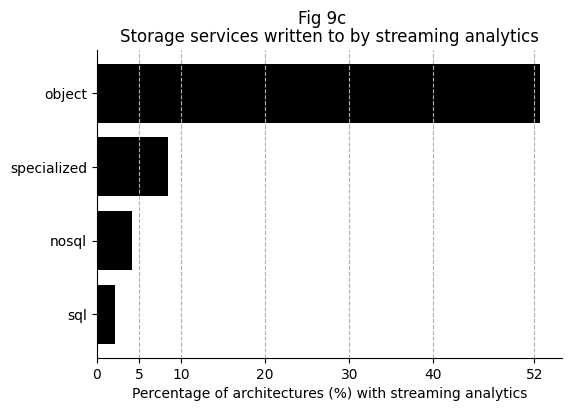

In [17]:
def fig_9c(architectures):
    """Which storage services do streaming analytics write to?"""
    # query
    n_archs_with_atleast_1_streaming = 0
    schemas_used = Counter()

    for arch in architectures:
        analytics_svcs_in_arch = set(
            filter(lambda x: x in streaming_svcs, arch.get_all_nodes_services())
        )
        if not analytics_svcs_in_arch:
            continue
        n_archs_with_atleast_1_streaming += 1

        schemas_used_in_this_arch = set()
        for analytics_svc in analytics_svcs_in_arch:
            writing_to = arch.get_outbound_nodes_for_svc(analytics_svc, data_only=True)
            writing_to = filter(is_storage, (t["service"] for t in writing_to))
            schemas_used_in_this_arch.update(svc_info[x]["schema"] for x in writing_to)

        schemas_used.update(schemas_used_in_this_arch)

    schemas_used = Counter(
        normalize_dict(schemas_used, n_archs_with_atleast_1_streaming)
    )

    # plotting
    fig, ax = plt.subplots(figsize=(6, 4))
    y = np.arange(len(schemas_used))
    y_names, x = zip(*reversed(schemas_used.most_common()))
    ax.barh(y, x, color="k")

    ax.set_yticks(y)
    ax.set_yticklabels(y_names)
    ax.set_xlabel("Percentage of architectures (%) with streaming analytics")
    ax.set_title("Storage services written to by streaming analytics")
    ax.grid(axis="x", linestyle="--")
    ax.set_xticks([0, 5, 10, 20, 30, 40, 52])

    plt.suptitle("Fig 9c")

    cleanup()


fig_9c(architectures)

The submitted version of the paper had a bug and reported 66% occurence of blob stores. 
We will update the graph with this corrected version (52.5%). 
This does not affect the claims made in the paper.

In [18]:
def table_3a(architectures):
    """Number of unique storage services used in each architecture"""
    archs_with_n_unique_svcs = Counter()

    for arch in architectures:
        storage_svcs = set(filter(is_storage, arch.get_all_nodes_services()))
        archs_with_n_unique_svcs.update([len(storage_svcs)])

    archs_with_n_unique_svcs = Counter(
        normalize_dict(archs_with_n_unique_svcs, len(architectures))
    )

    cum = 0
    for v in sorted(archs_with_n_unique_svcs.keys()):
        cum += archs_with_n_unique_svcs[v]
        print(
            "Cumulative percentage of architectures with <=",
            v,
            f"unique storage services: {cum:.2f}%",
        )


print("Table 3a")
table_3a(architectures)

Table 3a
Cumulative percentage of architectures with <= 0 unique storage services: 10.00%
Cumulative percentage of architectures with <= 1 unique storage services: 47.65%
Cumulative percentage of architectures with <= 2 unique storage services: 86.76%
Cumulative percentage of architectures with <= 3 unique storage services: 98.24%
Cumulative percentage of architectures with <= 4 unique storage services: 99.71%
Cumulative percentage of architectures with <= 5 unique storage services: 100.00%


In [19]:
def table_3b(architectures):
    """Co-occurence of storage schemas"""
    consider_schemas = ["sql", "nosql", "object"]

    def extract_storage_schemas(arch):
        storage_svcs = filter(is_storage, arch.get_all_nodes_services())
        storage_schemas = set(svc_info[x]["schema"] for x in storage_svcs)
        storage_schemas = [x for x in storage_schemas if x in consider_schemas]
        return storage_schemas

    df, more_than_2, _, _ = calculate_2d_cooccurence_df_plus_listofmore(
        architectures, consider_schemas, extract_storage_schemas
    )

    print(df)
    print(
        "Number of architectures with more than 2 storage schemas:",
        len(more_than_2),
        f"({len(more_than_2)/len(architectures)*100:.2f}%)",
    )


print("Table 3b")
table_3b(architectures)

Table 3b
             sql      nosql     object
sql      5% (19)    6% (21)   13% (45)
nosql    6% (21)    8% (30)   20% (70)
object  13% (45)   20% (70)   28% (96)
Total   25% (85)  35% (121)  62% (211)
Number of architectures with more than 2 storage schemas: 20 (5.88%)


In [20]:
def table_3c(architectures):
    """Number of different storage services per workflow"""

    arch_with_n_different_storage = Counter()

    for arch in architectures:
        different_storage_svcs_seen_per_flow = []
        for flow in arch.iterate_flows():
            nodes_in_flow = set()
            for edge in flow:
                nodes_in_flow.add(arch.nx_graph.nodes[edge[0]]["service"])
                nodes_in_flow.add(arch.nx_graph.nodes[edge[1]]["service"])
            storage_svcs_in_flow = len(
                list(filter(lambda x: is_storage(x), nodes_in_flow))
            )
            different_storage_svcs_seen_per_flow.append(storage_svcs_in_flow)

        max_interacting_svcs_seen_in_this_arch = max(
            different_storage_svcs_seen_per_flow
        )
        arch_with_n_different_storage.update([max_interacting_svcs_seen_in_this_arch])

    arch_with_n_different_storage = Counter(
        normalize_dict(arch_with_n_different_storage, len(architectures))
    )

    # plotting
    cum = 0
    for v in sorted(arch_with_n_different_storage.keys(), reverse=True):
        cum += arch_with_n_different_storage[v]
        print(
            "Cumulative percentage of architectures with >=",
            v,
            f"different storage services: {cum:.2f}%",
        )


print("Table 3c")
table_3c(architectures)

Table 3c
Cumulative percentage of architectures with >= 4 different storage services: 0.88%
Cumulative percentage of architectures with >= 3 different storage services: 4.71%
Cumulative percentage of architectures with >= 2 different storage services: 35.29%
Cumulative percentage of architectures with >= 1 different storage services: 89.12%
Cumulative percentage of architectures with >= 0 different storage services: 100.00%
